In [1]:
from maelzel.core import *
from pitchtools import *

csoundengine.magic extension loaded
Magics available: %csound, %%csound, %%definstr


## Config

Within *maelzel.core* **there is, at any moment, an active config object** (an instance of `CoreConfig`). This config encompasses settings related to notation, playback, quantization and many other aspects of *maelzel.core*. It is a subclass of *dict* with a fixed set of possible keys

In [2]:
# Get the active config

conf = getConfig()
conf

Key,Value,Type,Descr
A4,442,between 10 - 10000,"Freq. of the Kammerton A4. Normal values are 440, 442, 443 or 432 for old tuning, but any 'fantasy' value can be used"
splitAcceptableDeviation,4,type: int,"When splitting notes between staves, notes within this range of the split point will be grouped together if they all fit"
show.arpeggiateChord,auto,"{auto, False, True}","Arpeggiate notes of a chord when showing. In auto mode, only arpeggiate when needed"
chord.adjustGain,True,type: bool,"Adjust the gain of a chord according to the number of notes, to prevent clipping"
m21.displayhook.install,True,type: bool,None
m21.displayhook.format,xml.png,"{lily.png, xml.png}",None
m21.fixStream,True,type: bool,"If True, fix the streams returned by .asmusic21 (see m21fix)"
repr.showFreq,False,type: bool,Show frequency when calling printing a Note in the console
semitoneDivisions,4,"{1, 2, 4}","The number of divisions per semitone (2=quarter-tones, 4=eighth-tones)"
dynamicCurve.shape,expon(0.3),type: str,"The shape used to create the default dynamics curve. The most convenient shape is some variation of an exponential, given as expon(exp), where exp is the exponential used. exp < 1 will result in more resolution for soft dynamics"


**The config is at its core a dict where only a well defined set of keys are allowed and values are validated**. All operations on a built-in dict can be performed. 
To create a new configuration with some values modified, use `makeConfig` or call `.clone` on any config

For example, here we **create a new config** with a custom reference frequency. This modifies the reference frequency for any operation converting frequency to midinote or note name. After evaluating the following cell one can confirm that a frequency of 442 Hz is now 12 cents lower than A4

In [5]:
makeConfig({'A4': 445}, active=True)

f2n(442)

'4A-12'

To restore the original frequency, just modify the value of the active config:

In [5]:
getConfig()['A4'] = 442
f2n(442)

'4A'

Or activate the previous config

In [6]:
conf.activate()
f2n(442)

'4A'

-----------------

## Validation

A `CoreConfig` is also aware about valid values for its keys. For example, you can customize the number of playback channels used by the sound engine, or the
latency used for scheduling events. 

In [6]:
# Set the default number of channels for playback. Any playback engine created will use this setting
conf['play.numChannels'] = 4
conf['play.schedLatency'] = 0.1

A wrong type or range will throw an error and the previous value will not be overwritten so that the configuration remains in a usable state.

In [7]:
conf['play.numChannels'] = 'four'

ValueError: Expected int for key play.numChannels, got str

## Persistence

Customizations can be made persistent by calling `save` on the dictionary (independently of it being active). After that, any config created in a future session will use this dict as its default

In [5]:
conf.save()

To revert a config to its factory defaults, use `reset`

In [8]:
conf.reset()
conf['play.numChannels']

2

## Customizing playback / recording

By default any Note/Chord is played back using the default instr, which is a built-in piano soundfont. It is possible to customize the default instrument: 

In [3]:
defPresetSoundfont("accordion", "/home/em/Lib/snd/sf2/Accordion.sf2")

Preset: accordion  
  init: iSfTable_ sfloadonce "/home/em/Lib/snd/sf2/Accordion.sf2"
    ipresetidx sfPresetIndex "/home/em/Lib/snd/sf2/Accordion.sf2", 0, 0
    inote0_ = round(p(idataidx_ + 1))
    ivel_ = p(idataidx_ + 2) * 127
    aout1, aout2 sfplay ivel_, inote0_, kamp/16384, mtof:k(kpitch), ipresetidx, 1
  epilogue:
    turnoffWhenSilent aout1

In [4]:
conf['play.instr'] = 'accordion'

We create a simple chromatic scale to have something to play with

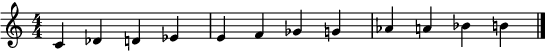

OfflineRenderer(sr=44100)
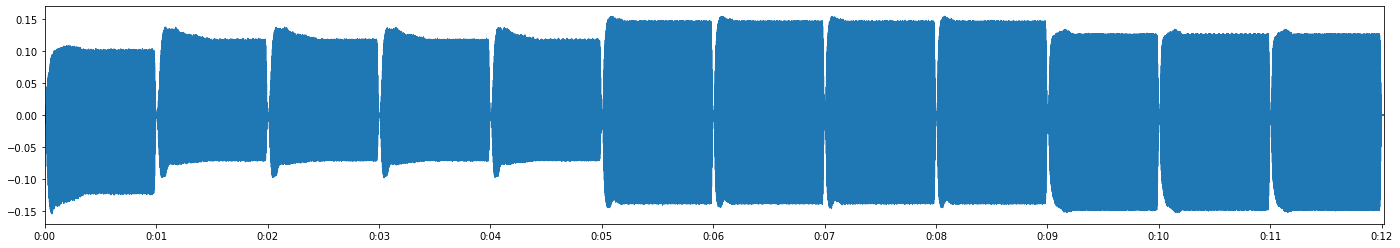

In [6]:
scale = Chain([Note(m, dur=1) for m in range(60, 72)])
scale.show()
scale.play()

OfflineRenderer(sr=48000)
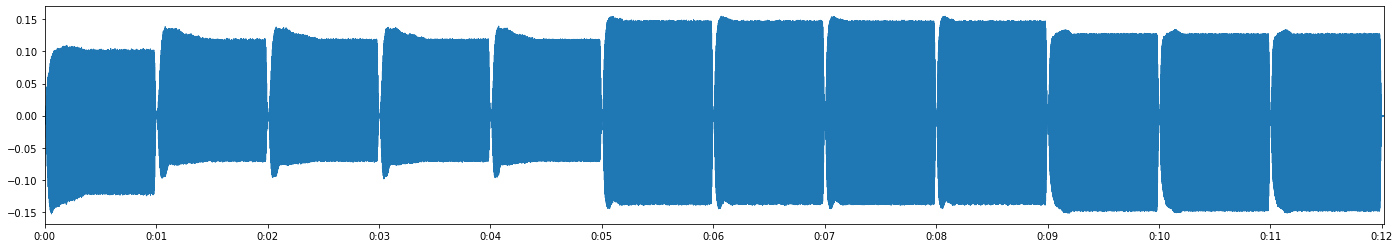

In [9]:
conf['rec.quiet'] = True  # do not output debugging info when rendering audio
conf['rec.sr'] = 48000     # set default recording samplerate
scale.rec('snd/scale-with-new-default-instr.ogg',nchnls=1)

----------------

## Workspace

At any moment there is one (and only one) active workspace. A workspace contains the following attributes:

* `.config` (`CoreConfig`): a config 
* `.scorestruct` (`ScoreStruct`): a score structure 
* `.dynamicCurve`: a dynamics curve, mapping dynamics to amplitudes
* internal attributes which determine the current state

In [12]:
w = getWorkspace()
w

Workspace(name=root, scorestruct=ScoreStruct(tempo=60, timesig=(4, 4)), dynamicCurve=DynamicCurve(shape=expon(0.3), mindb=-60.0, maxdb=0.0))

In [13]:
if w.isActive():
    print("This is the active workspace")

if w.config is getConfig():
    print("Its config is active")
    

This is the active workspace
Its config is active


By default a new Workspace includes a score structure of 4/4, quarter=60 bpm

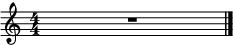

In [ ]:
w.scorestruct.show()

By modifiying the `.scorestruct` attribute or using the `setScoreStruct()` function it is possible to change the active score struct. Any playback or notation operation will now refer to this new score structure

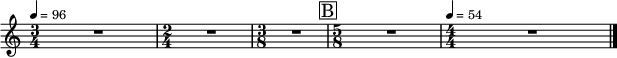

In [14]:
w.scorestruct = ScoreStruct('3/4, 96; 2/4; 3/8; 5/8,,B; 4/4, 54')
w.scorestruct.show()

The same scale from before will now be fitted to the new structure

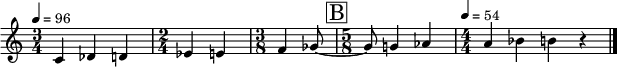

OfflineRenderer(sr=48000)
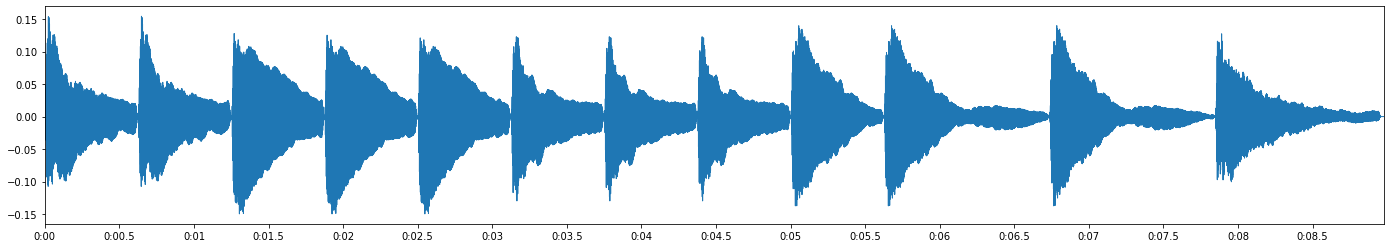

In [15]:
scale.show()
scale.rec(instr='piano', quiet=True, wait=True, nchnls=1)

## Ad-hoc contexts

It is possible to create a Workspace for an ad-hoc operation. After exiting the context the previous state is reset

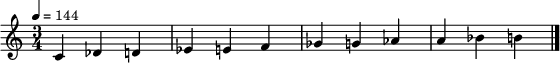

OfflineRenderer(sr=48000)
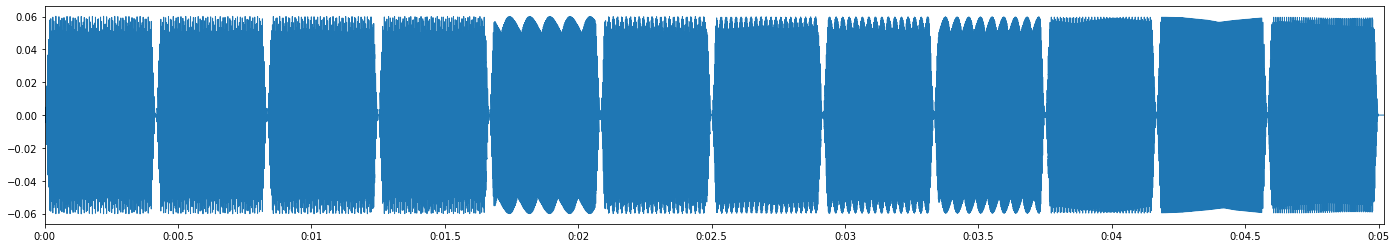

Now we are outside the context, so the previous workspace is active again


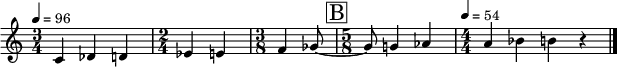

In [21]:
with Workspace(updates={'play.instr': 'saw'}, scorestruct=ScoreStruct('3/4, 144; ...')):
    scale.show()
    display(scale.rec(gain=0.1, wait=True, nchnls=1))

print("Now we are outside the context, so the previous workspace is active again")
scale.show()

If you only need to modify the config or the scorestructure for an ad-hoc operation it is possible to create a context with just one of them:

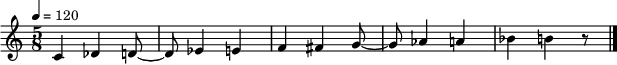

In [36]:
with ScoreStruct(timesig=(5, 8), quarterTempo=120):
    scale.play()
    scale.show()

OfflineRenderer(sr=44100)
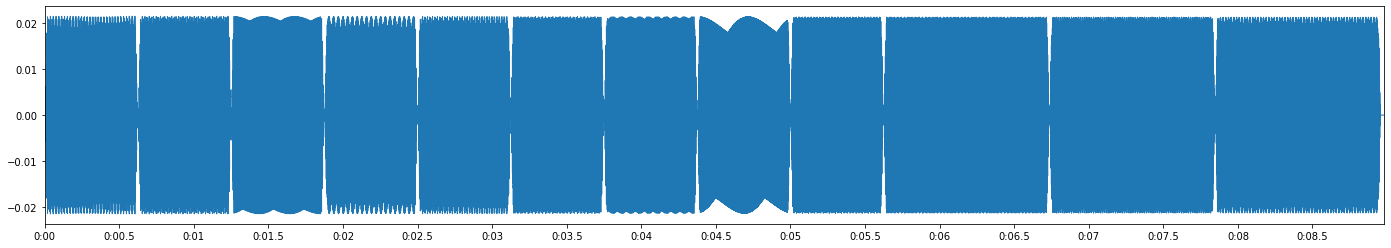

In [18]:
with makeConfig({'play.instr': 'saw'}):
    display(scale.rec(gain=0.1, wait=True, quiet=True, nchnls=1))

Or you can use multiple contexts at the same time

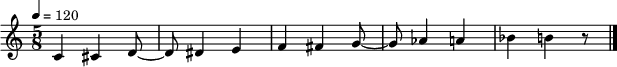

OfflineRenderer(sr=44100)
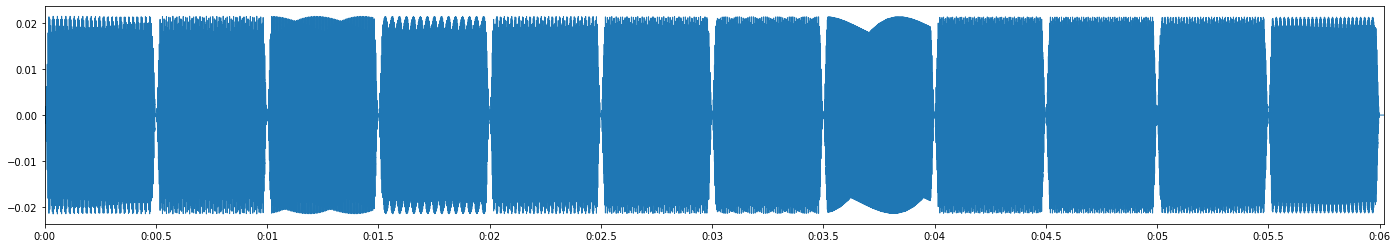

In [10]:
with ScoreStruct(timesig=(5, 8), quarterTempo=120), makeConfig({'play.instr': 'saw'}):
    scale.show()
    display(scale.rec(gain=0.1, wait=True, nchnls=1))